# Local Interpretability

In [ ]:
#default_exp core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#exporti
from fastai.vision import *
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gif

In [ ]:
#exporti
def dice(rotatedPrediction, trueMask, component = 1):
    dice = 1
    pred = rotatedPrediction.data == component
    msk = trueMask.data == component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        dice = 2 * intersect.sum().float() / total
    return dice.item()

## Sensitivity Analysis

### Example data (kaggle)

In [ ]:
img = lambda: open_image("example/kaggle/images/1-frame014-slice005.png")
trueMask = lambda: open_mask("example/kaggle/masks/1-frame014-slice005.png")
trainedModel = load_learner(path="example/kaggle", file="model.pkl", tfm_y=False)

### Rotation

In [ ]:
#export
def plot_rotation_series(image_function, model, start=0, end=180, num=5):
    fig, axs = plt.subplots(1,num,figsize=(16,6))
    for deg, ax in zip(np.linspace(start,end,num), axs):
        img = image_function().resize(256).rotate(degrees=int(deg))
        img.show(ax=ax, title=f'degrees={deg}', y =  model.predict(img)[0])

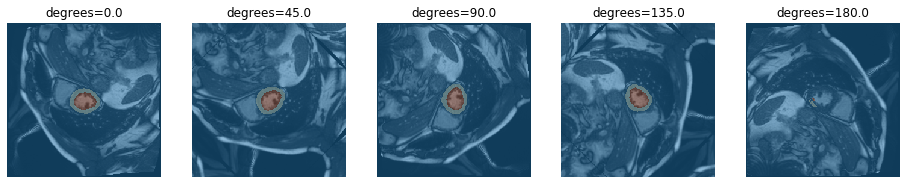

In [ ]:
plot_rotation_series(img, trainedModel)

In [ ]:
#export
def rotation_series(image_function, mask_function, model, step_size=5):
    trueMask = mask_function().resize(256)
    results = list()
    for deg in tqdm(range(0, 360, step_size)):
        image = image_function().resize(256)
        rotatedImage = image.rotate(degrees=deg)
        prediction = model.predict(rotatedImage)[0]
        prediction._px = prediction._px.float()
        rotatedPrediction = prediction.rotate(degrees=-deg)
        diceLV = dice(rotatedPrediction, trueMask, component = 1)
        diceMY = dice(rotatedPrediction, trueMask, component = 2)
        results.append([deg, diceLV, diceMY])

    results = pd.DataFrame(results,columns = ['deg', 'diceLV', 'diceMY'])
    return results

[0, 360, 0, 1]

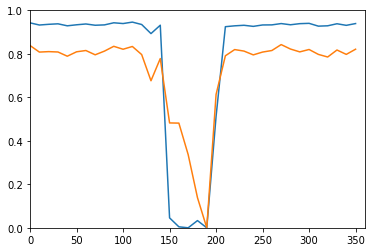

In [ ]:
results = rotation_series(img, trueMask, trainedModel, step_size=10)
plt.plot(results['deg'], results['diceLV'])
plt.plot(results['deg'], results['diceMY'])
plt.axis([0,360,0,1])

In [ ]:
#export
@gif.frame
def plot_rotation(image_function, model, deg=90):
    img = image_function().resize(256).rotate(degrees=int(deg))
    return img.show(title=f'degrees={deg}', y =  model.predict(img)[0])

You can easily generate gifs by plotting multiple frames

In [ ]:
frames = [plot_rotation(img,trainedModel,x) for x in tqdm(range(0,360,5))]

In [ ]:
gif.save(frames, "example/kaggle/rotation.gif", duration=150)

![segmentation sensitivity to rotation](example/kaggle/rotation.gif)

### Cropping

In [ ]:
#export
def plot_crop_series(image_function, model, start=256, end=56, num=5):
    fig, axs = plt.subplots(1,num,figsize=(16,6))
    for pxls, ax in zip(np.linspace(start,end,num), axs):
        croppedImage = image_function()
        croppedImage.resize(256)
        croppedImage.crop(int(pxls))
        croppedImage.rotate(180)
        croppedImage.crop_pad(256, padding_mode = 'zeros')
        croppedImage.rotate(180)
        croppedImage.show(ax=ax, title=f'pixels={int(pxls)}', y =  model.predict(croppedImage)[0])

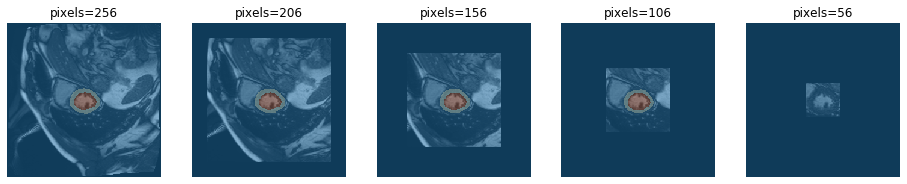

In [ ]:
plot_crop_series(img, trainedModel)

In [ ]:
#export
def crop_series(image_function, mask_function, model, step_size=5):
    results = list()
    for pxls in tqdm(range(256, 32, -step_size)):
        image = image_function()
        image.resize(256)
        trueMask = mask_function()
        trueMask.resize(256)

        # use double rotation to avoid cropping and padding with odd numbers to lead to 1px offset
        croppedImage = image.crop(pxls).rotate(180).crop_pad(256, padding_mode = 'zeros').rotate(180)
        prediction = model.predict(croppedImage)[0]
        prediction._px = prediction._px.float()

        diceLV = dice(prediction, trueMask, component = 1)
        diceMY = dice(prediction, trueMask, component = 2)
        results.append([pxls, diceLV, diceMY])

    results = pd.DataFrame(results,columns = ['pxls', 'diceLV', 'diceMY'])
    return results

[0, 256, 0, 1]

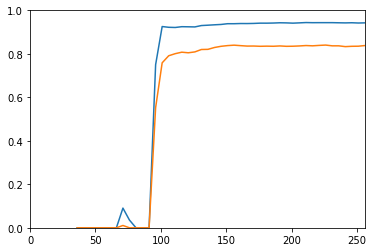

In [ ]:
results = crop_series(img, trueMask, trainedModel, step_size=5)
plt.plot(results['pxls'], results['diceLV'])
plt.plot(results['pxls'], results['diceMY'])
plt.axis([0,256,0,1])

In [ ]:
#export
@gif.frame
def plot_crop(image_function, model, pxls, **kwargs):
    img = image_function().resize(256).crop(pxls).rotate(180).crop_pad(256, padding_mode = 'zeros').rotate(180)
    return img.show(title=f'cropping={pxls}', y =  model.predict(img)[0], **kwargs)

In [ ]:
frames1 = [plot_crop(img,trainedModel,x) for x in tqdm(range(256,32,-5))]

In [ ]:
gif.save(frames1, "example/kaggle/crop.gif", duration=150)

![segmentation sensitivity to cropping](example/kaggle/crop.gif)

### Brightness

In [ ]:
#export
def plot_brightness_series(image_function, model, start=0.1, end=0.9, num=5):
    fig, axs = plt.subplots(1,num,figsize=(16,6))
    for change, ax in zip(np.linspace(start,end,num), axs):
        BrightImage = image_function()
        BrightImage.resize(256)
        BrightImage.brightness(change)
        BrightImage.show(ax=ax, title=f'brightness={change}', y =  model.predict(BrightImage)[0])

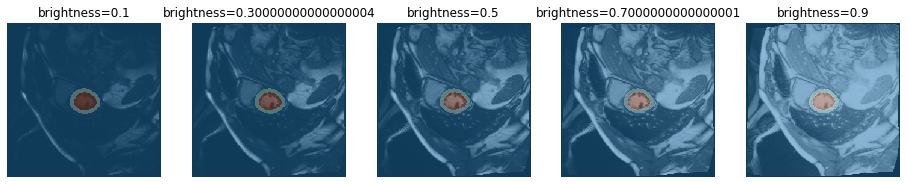

In [ ]:
plot_brightness_series(img, trainedModel)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_local_interpret.ipynb.
Converted index.ipynb.
